In [ ]:
#!pip install mxnet==1.6.0b20191124
!pip install d2l==0.11.0
!pip install mxnet-cu101==1.6.0b20191122

In [ ]:
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
import d2l
import zipfile
import matplotlib 
from matplotlib import pyplot as plt

npx.set_np()


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
galaxies = gluon.data.vision.datasets.ImageFolderDataset("/content/drive/My Drive/data123")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
batch_size = 20
transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)
])
data_iter = gluon.data.DataLoader(
    galaxies.transform_first(transformer), batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())
'''data_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
for i, j in data_iter:
  print(i.shape)
  break'''

'data_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)\nfor i, j in data_iter:\n  print(i.shape)\n  break'

(20, 64, 64, 3)


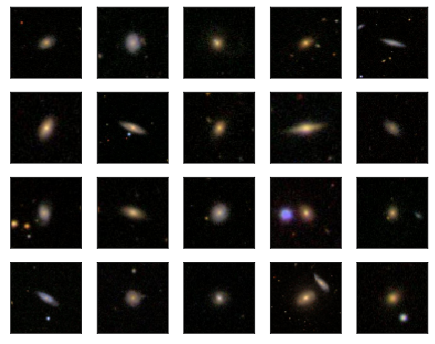

In [ ]:
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].transpose(0, 2, 3, 1)/2+0.5
    print(imgs.shape)
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break


In [ ]:
class G_block(nn.Block):
    def __init__(self, channels, kernel_size=4,
                 strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))


In [ ]:
n_G = 64
net_G = nn.Sequential()
net_G.add(G_block(n_G*8, strides=1, padding=0),  # output: (64*8, 4, 4)
          G_block(n_G*4),  # output: (64*4, 8, 8)
          G_block(n_G*2),  # output: (64*2, 16, 16)
          G_block(n_G),   # output: (64, 32, 32)
          nn.Conv2DTranspose(
              3, kernel_size=4, strides=2, padding=1, use_bias=False,
              activation='tanh'))  # output: (3, 64, 64)


In [ ]:
class D_block(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))


In [ ]:
n_D = 64
net_D = nn.Sequential()
net_D.add(D_block(n_D),   # output: (64, 32, 32)
          D_block(n_D*2),  # output: (64*2, 16, 16)
          D_block(n_D*4),  # output: (64*4, 8, 8)
          D_block(n_D*8),  # output: (64*8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # output: (1, 1, 1)


In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          ctx=d2l.try_gpu()):
    print("training begins")
    loss = gluon.loss.SigmoidBCELoss()
    net_D.initialize(init=init.Normal(0.02), force_reinit=True, ctx=ctx)
    net_G.initialize(init=init.Normal(0.02), force_reinit=True, ctx=ctx)
    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}
    trainer_D = gluon.Trainer(net_D.collect_params(), 'adam', trainer_hp)
    trainer_G = gluon.Trainer(net_G.collect_params(), 'adam', trainer_hp)
   # animator = d2l.Animator(xlabel='epoch', ylabel='loss',
    #                        xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
     #                       legend=['discriminator', 'generator'])
    #animator.fig.subplots_adjust(hspace=0.3)
    l_g, l_d = [], []
    for epoch in range(1, num_epochs+1):
        if (epoch % 10 == 0):
          print("epoch:", epoch)
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = np.random.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.as_in_context(ctx), Z.as_in_context(ctx),
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = np.random.normal(0, 1, size=(21, latent_dim, 1, 1), ctx=ctx)
        # Noramlize the synthetic data to N(0, 1)
        fake_x = net_G(Z).transpose(0, 2, 3, 1)/2+0.5
        imgs = np.concatenate(
            [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
             for i in range(len(fake_x)//7)], axis=0)
     #   print("everything done, only animate")
      #  animator.axes[1].cla()
       # animator.axes[1].imshow(imgs.asnumpy())
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        l_d.append(loss_D)
        l_g.append(loss_G)
        # animator.add(epoch, (loss_D, loss_G))
    plt.plot(l_d)
    plt.plot(l_g)
    plt.show()
    print('loss_D %.3f, loss_G %.3f, %d examples/sec on %s' % (
        loss_D, loss_G, metric[2]/timer.stop(), ctx))
    return imgs


In [ ]:
import time
start = time.time()

latent_dim, lr, num_epochs = 100, 0.006, 1000
imgs = train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)
plt.imshow(imgs.asnumpy())        W `1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            `1

print("time taken:",time.time()-start)
plt.show()

training begins
epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
epoch: 80
epoch: 90
epoch: 100
epoch: 110
epoch: 120
epoch: 130
epoch: 140
epoch: 150
epoch: 160
epoch: 170
epoch: 180
epoch: 190
epoch: 200
epoch: 210
epoch: 220
epoch: 230
epoch: 240
epoch: 250
epoch: 260
epoch: 270
epoch: 280
epoch: 290
epoch: 300
epoch: 310
epoch: 320
epoch: 330
epoch: 340
epoch: 350
epoch: 360
epoch: 370
epoch: 380
epoch: 390
epoch: 400
epoch: 410
epoch: 420
epoch: 430
epoch: 440
epoch: 450
epoch: 460
epoch: 470
epoch: 480
epoch: 490
epoch: 500
epoch: 510
epoch: 520
epoch: 530
epoch: 540
epoch: 550
epoch: 560
epoch: 570
epoch: 580
epoch: 590
epoch: 600
epoch: 610
epoch: 620
epoch: 630
epoch: 640
epoch: 650
epoch: 660
epoch: 670
epoch: 680
epoch: 690
epoch: 700
epoch: 710
epoch: 720
epoch: 730
epoch: 740
epoch: 750
epoch: 760
epoch: 770
epoch: 780
epoch: 790
epoch: 800
epoch: 810
epoch: 820


In [ ]:
net_D.save_parameters("discriminator_10_0.006_1000.h5")
net_G.save_parameters("gen_10_0.006_1000.h5")